# 2021/12/06

In [2]:
import pandas as pd
import numpy as np
import sys, os

In [3]:
input_path='/pod/2/li-lab/Ziwei/Nanopore/daily/test/'
#df=pd.read_csv(os.path.join(input_path, 'total.Megalodon.per_read.prob.bed.gz'),compression='gzip', sep='\t')
df=pd.read_csv(os.path.join(input_path, 'total.test.bed'), sep='\t')
print("Data is loading!")

df

Data is loading!


,chr,start,read_id,strand,5hmC_prob,5mC_prob,5C_prob,label
0,KJ477685.1,204,3e547b1a-0a3e-4475-9b70-0cbd7c8c82aa,-,0.435397,0.085058,0.479545,2
1,KJ477685.1,261,3e547b1a-0a3e-4475-9b70-0cbd7c8c82aa,-,0.342189,0.500821,0.156990,2
2,KJ477685.1,261,fe8be0cc-f4c4-49f1-80db-c840a6c7dfe9,-,0.577034,0.057676,0.365290,2
3,KJ477685.1,266,3e547b1a-0a3e-4475-9b70-0cbd7c8c82aa,-,0.065316,0.861569,0.073115,2
4,KJ477685.1,266,fe8be0cc-f4c4-49f1-80db-c840a6c7dfe9,-,0.794235,0.028885,0.176880,2
...,...,...,...,...,...,...,...,...
2492,J02459.1,60,bb826a6c-c88b-45ac-9984-8b9d6bfb2f11,-,0.054875,0.013023,0.932103,0
2493,J02459.1,60,bb91267a-6661-4248-a084-554f231398c1,-,0.030720,0.004392,0.964888,0
2494,J02459.1,60,bb9cee29-89d0-4a68-a4b4-8fe5c000289f,-,0.032703,0.006934,0.960363,0
2495,J02459.1,60,bbee6b4a-acac-4db9-bbb8-2f379918b146,-,0.035734,0.003182,0.961085,0


In [4]:
df['label'].value_counts()

1    999
0    999
2    499
Name: label, dtype: int64

In [5]:
#Splitting the data into independent and dependent variables
df_feature = df.loc[:,['5hmC_prob','5mC_prob']]
df_class = df.loc[:,['label']].values
df_class = np.squeeze(df_class) #Convert the label into 1d-array

# Train and split

In [6]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score

from collections import Counter

In [7]:
X = df_feature
y = df_class

#Split the data into training, validation, testing
#    Randomly split dataset, based on these ratios:
#        'train': train_frac
#        'valid': (1-train_frac) / 2
#        'test':  (1-train_frac) / 2
#    Eg: passing train_frac=0.8 gives a 80% / 10% / 10% split

X_tmp, X_test, y_tmp, y_test = train_test_split(X,
                                                y,
                                                train_size=0.8,
                                                stratify=y,
                                                random_state=42)

#Split the data into training and testing
X_train, X_val, y_train, y_val = train_test_split(X_tmp,
                                                  y_tmp,
                                                  train_size=0.8,
                                                  stratify=y_tmp,
                                                  random_state=42)
print("Before the pipeline:\n y_train:{},\n y_val:{},\n y_test: {}".format(Counter(y_train), Counter(y_val), Counter(y_test)))
print("Spliting is done!")

Before the pipeline:
 y_train:Counter({0: 639, 1: 639, 2: 319}),
 y_val:Counter({0: 160, 1: 160, 2: 80}),
 y_test: Counter({0: 200, 1: 200, 2: 100})
Spliting is done!


## Downsampling with RandomUnderSampler

### testing dataset

In [33]:
n = np.bincount(y_test)[-1]
key=[0,1,2]
value = [(1*n, 1*n, n)] ###Set up the ratio
for i in value:
    sampling_strategy = dict(zip(key, i)).copy()

sampler = RandomUnderSampler(random_state = 42, sampling_strategy=sampling_strategy)

X_test_res, y_test_res = sampler.fit_resample(X_test, y_test)

print("Before downsampling: y_test: {},\nAfter downsampling:y_test_res: {}".format(Counter(y_test), Counter(y_test_res)))

Before downsampling: y_test: Counter({0: 200, 1: 200, 2: 100}),
After downsampling:y_test_res: Counter({0: 100, 1: 100, 2: 100})


## Use the list to create PredefinedSplit

In [9]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1597, 2), (1597,), (400, 2), (400,))

### Downsampling Validation dataset

In [10]:
n = np.bincount(y_val)[-1]
key=[0,1,2]
value = [(1*n, 1*n, n)] ###Set up the ratio
for i in value:
    sampling_strategy = dict(zip(key, i)).copy()

sampler = RandomUnderSampler(random_state = 42, sampling_strategy=sampling_strategy)

X_val_res, y_val_res = sampler.fit_resample(X_val, y_val)

print("Before downsampling: y_val: {},\nAfter downsampling:y_val_res: {}".format(Counter(y_val), Counter(y_val_res)))

Before downsampling: y_val: Counter({0: 160, 1: 160, 2: 80}),
After downsampling:y_val_res: Counter({0: 80, 1: 80, 2: 80})


### Exploration

In [11]:
X_val_res.index, X_val.index, X_train.index

(RangeIndex(start=0, stop=240, step=1),
 Int64Index([1624, 1127, 2141, 1755, 1492, 2254,  546,  398, 1257, 1733,
             ...
              423, 1920, 1851,  236, 1880, 1857,  483,  970,  561, 2107],
            dtype='int64', length=400),
 Int64Index([2351,  712,  910, 1209, 1387,  319, 1625, 2118,   47,  974,
             ...
             2028, 1441,   81,  342,  325,  526,  287, 1084, 2190,  219],
            dtype='int64', length=1597))

In [12]:
X_train.iloc[0, :]

5hmC_prob    0.042216
5mC_prob     0.004372
Name: 2351, dtype: float64

In [27]:
X_train

,5hmC_prob,5mC_prob
2351,0.042216,0.004372
712,0.000680,0.996772
910,0.000633,0.996441
1209,0.000476,0.998279
1387,0.001512,0.992194
...,...,...
526,0.000332,0.998129
287,0.003440,0.991833
1084,0.000225,0.999147
2190,0.050572,0.008937


In [28]:
X_val_res.iloc[0, :]

5hmC_prob    0.029553
5mC_prob     0.002052
Name: 0, dtype: float64

In [29]:
#https://stackoverflow.com/a/43766334
### Use PredefinedSplit
my_test_fold = []

# put -1 so they will be in training set
for i in range(len(X_train)):
    my_test_fold.append(-1)

# for all greater indices, assign 0, so they will be put in test set
for i in range(len(X_val_res)):
    my_test_fold.append(0)

pd.DataFrame(my_test_fold).value_counts()

-1    1597
 0     240
dtype: int64

In [30]:
#https://gist.github.com/anirudhshenoy/e87525499d66e8a46a56bfa27e2d2f2f
from scipy import sparse
X = sparse.vstack((X_train, X_val_res))
X

<1837x2 sparse matrix of type '<class 'numpy.float64'>'
	with 3674 stored elements in COOrdinate format>

In [15]:
test_fold = [-1 for _ in range(X_train.shape[0])] + [0 for _ in range(X_val_res.shape[0])]
pd.DataFrame(test_fold).value_counts()

-1    1597
 0     240
dtype: int64

## Define pipeline

In [16]:
# Pipeline strategy: SMOTE -> rf
###Build the pipeline
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
over = SMOTE(sampling_strategy='not majority', random_state = 42, n_jobs = -1)
steps = [('o', over), ('m', rf_model)]
pipeline = imbpipeline(steps=steps)

params = {
    'o__k_neighbors':[5, 10, 20],      
    'm__n_estimators': [i for i in range(50, 110, 10)], # number of trees in the random forest
    'm__max_features': ['auto'], # number of features in consideration at every split
    'm__max_depth': [i for i in range(5,30,5)], # maximum number of levels allowed in each decision tree
    'm__min_samples_split': [2,5,10], # minimum sample number to split a node
    'm__min_samples_leaf': [1,2], # minimum sample number that can be stored in a leaf node
    'm__bootstrap': [True, False]} # method used to sample data points"

In [38]:
# Use PredefinedSplit in GridSearchCV
from sklearn.model_selection import PredefinedSplit

#pipe_search = GridSearchCV(estimator = pipeline, 
#                           param_grid = params, 
#                           scoring='f1_macro', 
#                           cv=PredefinedSplit(test_fold = my_test_fold),
#                           verbose=3, 
#                           return_train_score=True, 
#                           n_jobs=-1)

pipe_search = RandomizedSearchCV(estimator = pipeline, 
                                 param_distributions = params, 
                                 scoring='f1_macro', 
                                 cv=PredefinedSplit(test_fold = my_test_fold),
#                                 verbose=3, 
                                 n_iter=20,
                                 return_train_score=True, 
                                 n_jobs=-1)

X_merge, y_merge = np.concatenate((X_train, X_val_res), axis=0), np.concatenate((y_train, y_val_res), axis=0)
pipe_result = pipe_search.fit(X_merge, y_merge)
y_true, y_pred = y_test_res, pipe_search.predict(X_test_res.values)

In [42]:
cv_score = pipe_result.best_score_
test_score = pipe_result.score(X_test.values, y_test)

print ('Best Parameters: ', pipe_result.best_params_, ' \n')
print('Best f1_score in cv:', cv_score, '\n')
print('Test score:', test_score)

Best Parameters:  {'o__k_neighbors': 20, 'm__n_estimators': 100, 'm__min_samples_split': 2, 'm__min_samples_leaf': 2, 'm__max_features': 'auto', 'm__max_depth': 5, 'm__bootstrap': False}  

Best f1_score in cv: 0.925585706073511 

Test score: 0.870509824104329


In [53]:
cm = confusion_matrix(y_true, y_pred)
    # Normalise
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmn = pd.DataFrame(cmn)
cmn

,0,1,2
0,0.94,0.00,0.06
1,0.00,0.89,0.11
2,0.14,0.06,0.80


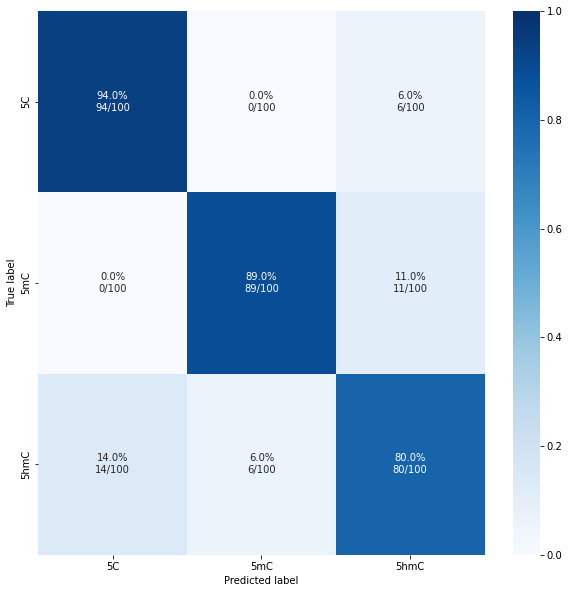

In [59]:
#https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
def plot_cm(y_true, y_pred, filename, label = ['5C', '5mC', '5hmC'], figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with annotations.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    cm = confusion_matrix(y_true, y_pred)
    # Normalise
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
    
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cmn = pd.DataFrame(cmn, index=label, columns=label)
    cmn.index.name = 'True label'
    cmn.columns.name = 'Predicted label'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cmn, annot=annot, fmt='', ax=ax, cmap="Blues", vmin=0, vmax=1)
#    plt.savefig(filename)

plot_cm(y_true, y_pred, os.path.join(input_path, "rf.GridSearch.confusion_matrix.png"), figsize=(10,10))